In [1]:
import pandas as pd
import networkx as nx
import pickle
import cobra
import matplotlib.pyplot as plt

In [2]:
G = pickle.load(open('yeast_G.pickle', 'rb'))

print(f'# Nodes: {G.number_of_nodes()} \n# Edges: {G.number_of_edges()}')

# Nodes: 373 
# Edges: 6157


In [3]:
cobra_model = cobra.io.load_json_model('redYeast_ST8943_fdp1.json')

### Study metabolic network using `Networkx`

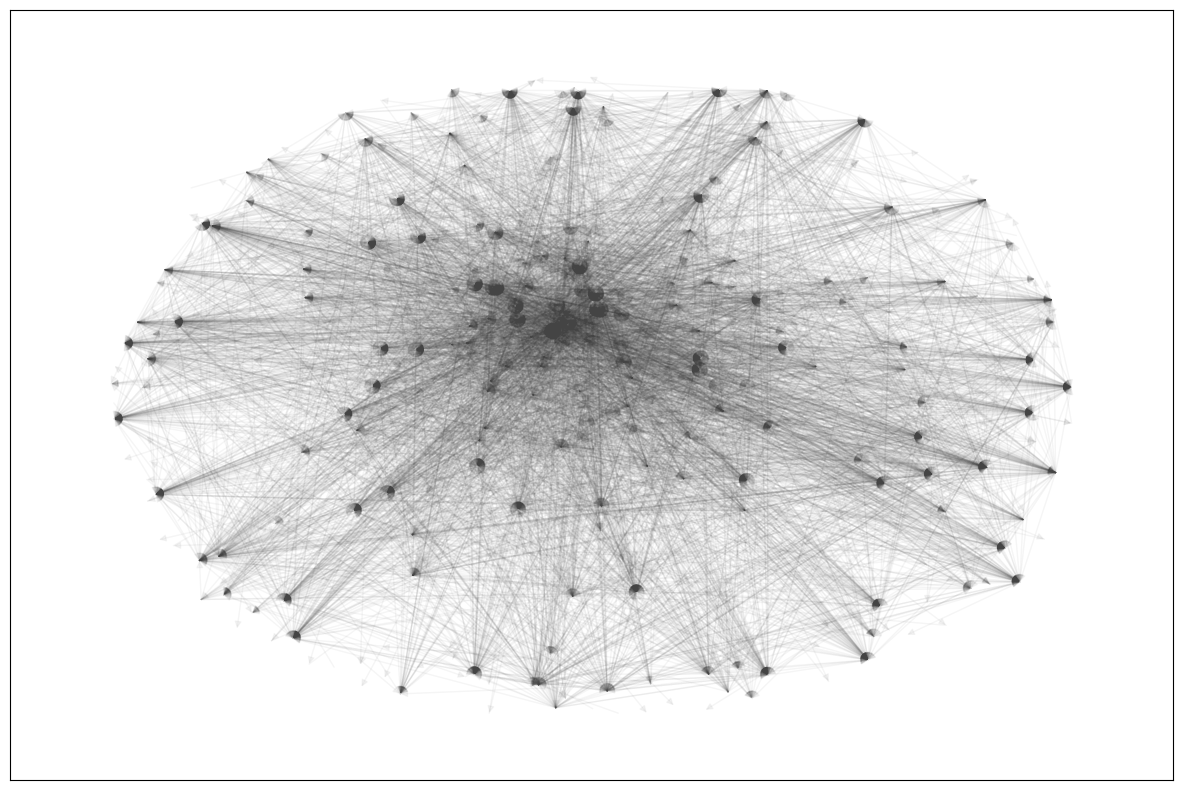

In [4]:
pos = nx.spring_layout(G, k=0.1)
plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw_networkx(
    G,
    pos=pos,
    node_size=0,
    edge_color="#444444",
    alpha=0.05,
    with_labels=False)

In [5]:
communities = sorted(nx.algorithms.community.greedy_modularity_communities(G), key=len, reverse=True)
len(communities)

15

In [6]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

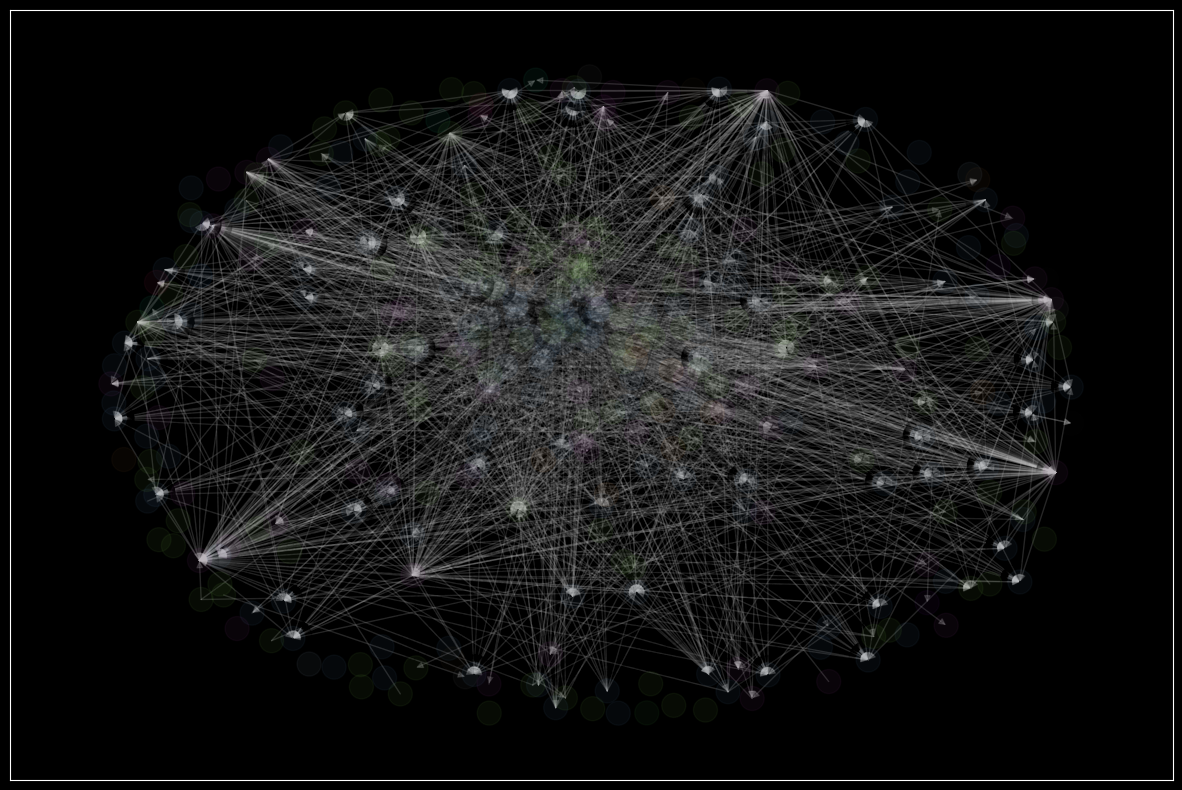

In [7]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
plt.style.use('dark_background')
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)
# Set community color for internal edges
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]
# external edges
nx.draw_networkx(
    G,
    pos=pos,
    node_size=0,
    edgelist=external,
    edge_color="silver",
    node_color=node_color,
    alpha=0.2,
    with_labels=False)
# internal edges
nx.draw_networkx(
    G, pos=pos,
    edgelist=internal,
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.05,
    with_labels=False)

plt.show()

In [ ]:
degrees = dict(G.degree())

# Sort the degrees by value
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], \
    reverse=True)

# Print the sorted degrees
sorted_degrees[:10]

In [ ]:
clusters = dict(nx.clustering(G))

sorted(clusters.items(), key=lambda x: x[1], reverse=True)

## Add node features

In [ ]:
# Add number of metabolites in every reaction as a node feature
for node, data in G.nodes(data=True):
    if "rev?" in node: rxn_name = node.split("?")[1]
    else: rxn_name = node
    
    num_metabolites = len(cobra_model.reactions.get_by_id(rxn_name).metabolites)
    data['x'] = num_metabolites

## Read ORACLE's data

In [ ]:
sigma = pd.read_csv('saturations.csv', index_col=0)
gamma = pd.read_csv('gamma.csv', index_col=0)
vmax = pd.read_csv('Vmax_matrix.csv', index_col=0)

gamma = gamma.head(1)
sigma = sigma.head(1)
vmax = vmax.head(1)

In [ ]:
# get the reactions that are the reversible 
rev_rxn = []
for node in list(G.nodes()):
    if node.split("?")[0] == 'rev': rev_rxn.append(node.split("?")[1])

# rename the reactions of gamma; if it's the reversible one add rev? to the column name
for col in gamma.columns:
    if col in rev_rxn: gamma.rename(columns={col:'rev?'+col}, inplace=True)

In [ ]:
listA = list(G.nodes())
listB = gamma.columns.values

print('In Graph but not in gamma:', [item for item in listA if item not in listB])
print()
print('In gamma but not in Graph:', [item for item in listB if item not in listA])

In [ ]:
# Drop nodes without gamma
G.remove_nodes_from([item for item in listA if item not in listB])
print(f'# Nodes: {G.number_of_nodes()} \n# Edges: {G.number_of_edges()}')

In [ ]:
# reactions with gamma > 1
rxn_bad_gamma = gamma.columns[(gamma > 1).any()].tolist()
gamma.drop(columns=rxn_bad_gamma, inplace=True)
print(gamma.shape)

# Drop nodes with gamma > 0
G.remove_nodes_from(rxn_bad_gamma)
print(f'# Nodes: {G.number_of_nodes()} \n# Edges: {G.number_of_edges()}')

#### Add `gamma` values as Graph node features

In [ ]:
for node in gamma.columns:
    try:
        G.nodes[node]['y'] =  gamma[node].values[0]
    except KeyError:
        pass

no_gamma_nodes = [node for node, data in G.nodes(data=True) if not data]

for node in no_gamma_nodes: G.nodes[node]['y'] = np.nan

#### Maybe, the Graph is ready afterall...

## Networkx to Torch Geometric

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.utils.convert import from_networkx

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data = from_networkx(G, group_edge_attrs=all)
data.x = data.x.view(-1,1).float()
data.y = data.y.float()

print(data)
print()
print(data.num_nodes ,data.num_edges)

In [ ]:
train_size = int(len(data.x) * 0.8)
val_size = int(len(data.x) * 0.1)
test_size = int(len(data.x) * 0.1)

# Create train, validation, and test masks
train_mask = torch.zeros(len(data.x), dtype=torch.bool)
train_mask[:train_size] = 1

val_mask = torch.zeros(len(data.x), dtype=torch.bool)
val_mask[train_size:train_size + val_size] = 1

test_mask = torch.zeros(len(data.x), dtype=torch.bool)
test_mask[train_size + val_size:] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

data

## Create a GNN

In [ ]:
import torch.nn.functional as F
from torch.optim import Optimizer
from torch_geometric.nn import GCNConv
from torch import Tensor
import torch.nn as nn
import torch

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.conv = GCNConv(input_dim, hidden_dim)
        self.relu = nn.ReLU(inplace=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x: Tensor, edge_index: Tensor) -> torch.Tensor:

        x = self.conv(x, edge_index)
        x = self.relu(x)
        x = self.linear(x)
        
        return x

In [ ]:
SEED = 42
MAX_EPOCHS = 1000
LEARNING_RATE = .01

INPUT_DIM = data.num_features
HIDDEN_DIM = 128

model = GCN(INPUT_DIM, HIDDEN_DIM)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

" ************ TRAIN FUNCTION **************"
def train():

    model.train() # Tells the model that we are in training mode
    optimizer.zero_grad() # Resets the gradient
    
    y_pred = model(data.x, data.edge_index) # predicted y
    y_true = data.y # True labels
    
    loss = criterion(y_pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    
    optimizer.step()
    return loss

" ************ TEST FUNCTION **************"
def test(mask):

    model.eval() # Tells the model that we are in testing mode

    y_pred = model(data.x, data.edge_index) # Preds for all data
    y_true = data.y
    
    mse = criterion(y_pred[mask], y_true[mask])

    return mse        

In [ ]:
VAL_ACCURACY = []
TEST_ACCURACY = []

for epoch in range(MAX_EPOCHS):

    loss = train()

    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)

    VAL_ACCURACY.append(val_acc)
    TEST_ACCURACY.append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, \
        Test: {test_acc:.4f}')


In [ ]:
y_pred = model(data.x, data.edge_index) # Preds for all data
y_pred = y_pred[data.test_mask]
y_pred

In [ ]:
y_true = data.y[data.test_mask]
y_true